# Read csv downloaded from NASCOP  to summarize it for DATIM and for our consumption:

In [1]:
%%time
# import pandas
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import calendar
import math


from plotly.subplots import make_subplots
import plotly.graph_objects as go

# plt.style.use('fivethirtyeight')
import seaborn as sns
from io import StringIO
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)

from collections import defaultdict
from IPython.display import display
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# read dataframe from the directory
# df=pd.read_csv('UON CRISSP EID TEST OUTCOMES FOR  IN 01OCT2020  31DEC2020.csv',index_col=None)
df=pd.read_csv('C:\\Users\\user\\Downloads\\UON CRISSP EID TEST OUTCOMES FOR  IN 01JUN2021  29SEP2021.csv',index_col=None)
df=df[df['County']=="Kiambu"]
# df=df[df['County']=="Kirinyaga"]                                                   
# df=df[df['Sub-County']=="Kirinyaga Central"]
# df=df[df['Sub-County']=="Kirinyaga East"]
# df=df[df['Sub-County']=="Kirinyaga North"]
# df=df[df['Sub-County']=="Kirinyaga South"]
# df=df[df['Sub-County']=="Kirinyaga North/Mwea West"]

Wall time: 7.28 s


In [2]:
from IPython.display import HTML
,
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
''')

In [3]:
def get_results(df):
    """Displays answer in form of a """  
    
    # get unique values in 'PCR type' column
    pcr_types=[] # store unique value from above in a list
    for pcr_type in df['PCR Type']: 
        df=df[df['PCR Type']==pcr_type]
        pcr_types.append(pcr_type)
        
    # count values in the pcr type list
    results = defaultdict(int)
    for pcr_type in pcr_types:
        results[pcr_type] += 1 
        
    #convert dictionary to a dataframe       
    num=pd.DataFrame(results.items(),columns=['PCR type','Count'],index=None )
    
    return num   

In [4]:
def age_buckets(x):
    """convert age to age ranges"""
    if x == 2: 
        return '< 2' 
    elif x == 12: 
        return '2-12' 

#####  PMTCT_EID Disaggregated by Infant Test Results
use table below to fill DATIM report

In [5]:
# change df to datim
summary_PCR_done=df

# Replace <2 with 2 and 2-12 with 12
summary_PCR_done.loc[summary_PCR_done['Age (Months)'] < 2, 'Age (Months)'] = 2
summary_PCR_done.loc[(summary_PCR_done['Age (Months)'] >2) & (summary_PCR_done['Age (Months)'] <12), 'Age (Months)'] = 12

# Filter all rows for which the children age is greater than >12. Not need in the report
summary_PCR_done.drop(summary_PCR_done[summary_PCR_done['Age (Months)'] > 12].index, inplace = True)
summary_PCR_done=summary_PCR_done[summary_PCR_done['PCR Type'] != 'Confirmatory PCR and Baseline VL']
# summary_PCR_done

In [6]:
# add a column of count to the dataframe
summary_PCR_done=summary_PCR_done.copy()
summary_PCR_done['Counts']=1

summary_PCR_done['Age'] = summary_PCR_done['Age (Months)'].apply(age_buckets)

# group dataframe by Facilty',"Result" and'Age (Months)'
facilities=summary_PCR_done.groupby(['County','Facilty','Result','Age']).sum()['Counts'].reset_index()
# facilities
# ages

# #convert summary into a dataframe 
# pd.DataFrame(summary_PCR_done,columns=['Count'])

In [7]:
df2=summary_PCR_done.groupby(["Sub-County",'Result','Age']).sum()['Counts'].reset_index()
subcounties=df2.pivot_table(index=['Sub-County', 'Age'], columns="Result").reset_index()

In [8]:
def convert_pivot_to_dataframe(subcounties):
    """convert pivot table to dataframe"""  
    subcounties.columns = subcounties.columns.droplevel(0) #remove amount
    subcounties = subcounties.reset_index()                #index to columns
    return subcounties
    
# subcounties

In [9]:
subcounties=convert_pivot_to_dataframe(subcounties)

subcounties.columns=["index","Sub-Counties","Months Initial PCR done","Negative","Positive"]
del subcounties['index']
subcounties=subcounties.fillna(0)
subcounties["Total"]=subcounties["Negative"]+subcounties["Positive"]
pcr_done=subcounties['Total'].sum().astype(int)
positive_sample=subcounties['Positive'].sum().astype(int)
negative_sample=subcounties['Negative'].sum().astype(int)
subcounties['Total']=subcounties['Total'].astype(int)
subcounties['Positive']=subcounties['Positive'].astype(int)
subcounties['Negative']=subcounties['Negative'].astype(int)
subcounties

,Sub-Counties,Months Initial PCR done,Negative,Positive,Total
0,Gatundu North,2-12,40,1,41
1,Gatundu North,< 2,9,0,9
2,Gatundu South,2-12,34,0,34
3,Gatundu South,< 2,13,0,13
4,Githunguri,2-12,33,2,35
5,Githunguri,< 2,14,0,14
6,Juja,2-12,37,0,37
7,Juja,< 2,9,0,9
8,Kabete,2-12,59,0,59
9,Kabete,< 2,21,0,21


In [10]:
negative=subcounties.groupby("Sub-Counties").sum()['Negative'].reset_index()
positives=subcounties.groupby("Sub-Counties").sum()[['Positive','Negative']].reset_index().sort_values("Negative")
positives['Total']=positives['Positive']+positives['Negative']


positives['Total']=positives['Total'].astype(int)
positives['Positive']=positives['Positive'].astype(int)
positives['Negative']=positives['Negative'].astype(int)
positives['mtct rate']=round(positives['Positive']/positives['Total']*100,1)
positives

,Sub-Counties,Positive,Negative,Total,mtct rate
8,Lari,0,15,15,0.0
7,Kikuyu,0,23,23,0.0
3,Juja,0,46,46,0.0
1,Gatundu South,0,47,47,0.0
2,Githunguri,2,47,49,4.1
0,Gatundu North,1,49,50,2.0
9,Limuru,0,62,62,0.0
5,Kiambaa,0,70,70,0.0
4,Kabete,0,80,80,0.0
6,Kiambu town,1,95,96,1.0


In [11]:
positives

,Sub-Counties,Positive,Negative,Total,mtct rate
8,Lari,0,15,15,0.0
7,Kikuyu,0,23,23,0.0
3,Juja,0,46,46,0.0
1,Gatundu South,0,47,47,0.0
2,Githunguri,2,47,49,4.1
0,Gatundu North,1,49,50,2.0
9,Limuru,0,62,62,0.0
5,Kiambaa,0,70,70,0.0
4,Kabete,0,80,80,0.0
6,Kiambu town,1,95,96,1.0


In [12]:

# positives=positives.sort_values('TX_CURR')
positives
# fig=px.bar(positives,x='Sub-Counties',y=['tx curr target','Negative ','Positive'],title=F"TX CURR BY SUB-COUNTIES N={total_curr}"
#            f"    Positive: {Positive}  Negative : {Negative }",hover_data=['tx curr target','TX_CURR','Sub-Counties','achievement %'],
#            labels={'tx curr target':'TX_CURR TARGET','TX_CURR':'Current TX_CURR'},barmode='group')

# texts=[positives['Negative '],positives['Positive']]
# for i, t in enumerate(texts):
#     fig.data[i].text = t
#     fig.data[i].textposition = 'outside'
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=positives['Sub-Counties'],
           y=positives['Negative'], name="Negative", text=positives['Negative'], textposition='outside'),
    secondary_y=False,
)
fig.add_trace(
go.Bar(x=positives['Sub-Counties'],
       y=positives['Positive'], name="Positive", text=positives['Positive'], textposition='outside'),
secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=positives['Sub-Counties'],
               y=positives['mtct rate'], name="mtct rate %", text=positives['mtct rate'], textposition='top center', mode="lines+markers+text",
              textfont_size=18,textfont=dict(
                                                family="sans serif",
                                                size=22,
                                                color="RED")),
    secondary_y=True,
)


# Add figure title
fig.update_layout(
    title_text=f"<b>Number of PCR done per Sub-county N= {pcr_done} Positive: {positive_sample}  Negative : {negative_sample }<b>"
)

# Set x-axis title
fig.update_xaxes(title_text="<b>SUB-COUNTIES<b>")

# Set y-axes titles
fig.update_yaxes(title_text="<b>PCR DONE</b> ", secondary_y=False)
fig.update_yaxes(title_text="<b>mtct rate</b>", secondary_y=True)

fig.show()

In [13]:
facilities=facilities.pivot_table(index=["County",'Facilty', 'Age'], columns="Result").reset_index()

facilities=convert_pivot_to_dataframe(facilities)

facilities.columns=["index","County","Facility","Months Initial PCR done","Negative","Positive"]
del facilities['index']
facilities=facilities.fillna(0)
facilities["Total PCRs done"]=facilities["Negative"]+facilities["Positive"]

facilities["Total PCRs done"]=facilities["Total PCRs done"].astype(int)
facilities["Positive"]=facilities["Positive"].astype(int)
facilities["Negative"]=facilities["Negative"].astype(int)
facilities

,County,Facility,Months Initial PCR done,Negative,Positive,Total PCRs done
0,Kiambu,Aid Intergrated Programme Mangu Dispensary,2-12,4,0,4
1,Kiambu,Aid Intergrated Programme Mangu Dispensary,< 2,3,0,3
2,Kiambu,Anmer Dispensary,2-12,2,0,2
3,Kiambu,Beta Care Nursing Home,2-12,4,0,4
4,Kiambu,Beta Care Nursing Home,< 2,1,0,1
5,Kiambu,Cianda Dispensary,2-12,1,0,1
6,Kiambu,Cianda Dispensary,< 2,2,0,2
7,Kiambu,Gachege Dispensary,< 2,2,0,2
8,Kiambu,Gachororo Health Centre,2-12,9,0,9
9,Kiambu,Gachororo Health Centre,< 2,3,0,3


In [14]:
facilities_pos=facilities[facilities['Positive']!=0]

facilities_pos=facilities_pos.copy()
facilities_pos['facilities'] = facilities_pos['Facility'].str.split().str[0]
del facilities_pos['Facility']

sorted_columns=['County', 'facilities','Months Initial PCR done', 'Negative', 'Positive',
       'Total PCRs done']

facilities_pos = facilities_pos.reindex(sorted_columns, axis=1)
facilities_pos=facilities_pos.groupby(['facilities','Months Initial PCR done']).sum()['Positive'].reset_index()
facilities_pos=facilities_pos.sort_values("Positive")
facilities_pos=facilities_pos.pivot(index="facilities",columns="Months Initial PCR done")
facilities_pos=convert_pivot_to_dataframe(facilities_pos)
facilities_pos=facilities_pos.fillna(0)


if ('< 2' and '2-12') in facilities_pos.columns:
    facilities_pos['2-12']=facilities_pos['2-12'].astype(int)
    facilities_pos['< 2']=facilities_pos['< 2'].astype(int)
    less_2_months=facilities_pos["< 2"].sum()
    two_to_twelve_months=facilities_pos["2-12"].sum()
    facilities_pos['total']=facilities_pos['< 2']+facilities_pos['2-12']
    total=facilities_pos['total'].sum()
    
elif '2-12' not in facilities_pos.columns:
#     facilities_pos['2-12']=facilities_pos['2-12'].astype(int)
    facilities_pos['< 2']=facilities_pos['< 2'].astype(int)
    less_2_months=facilities_pos["< 2"].sum()
    two_to_twelve_months=0
    facilities_pos['total']=facilities_pos['< 2']
    total=facilities_pos['total'].sum()
else:
    facilities_pos['2-12']=facilities_pos['2-12'].astype(int)
#     facilities_pos['< 2']=facilities_pos['< 2'].astype(int)
    less_2_months=0
    two_to_twelve_months=facilities_pos["2-12"].sum()
    facilities_pos['total']=facilities_pos['2-12']
    total=facilities_pos['total'].sum()
    

facilities_pos=facilities_pos.sort_values("total")

In [15]:
try:
    fig=px.bar(facilities_pos,x='facilities',y=['< 2','2-12'],title="<b>NUMBER OF POSITIVE SAMPLES DURING THE REVIEW PERIOD"
           f" N={total}   < 2 months: {less_2_months} ({round(less_2_months/(less_2_months+two_to_twelve_months)*100,)}%)  2-12 months: {two_to_twelve_months} ({round(two_to_twelve_months/(less_2_months+two_to_twelve_months)*100,)}%)<b>",
           barmode='group')

    texts=[facilities_pos['< 2'],facilities_pos['2-12']]
    for i, t in enumerate(texts):
        fig.data[i].text = t
        fig.data[i].textposition = 'outside'
    fig.update_layout(uniformtext_minsize=14, uniformtext_mode='hide')

    # Set x-axis title
    fig.update_xaxes(title_text="<b>Facilities<b>")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Positive PCRs</b> ", secondary_y=False)
    # fig.update_yaxes(title_text="<b>CONTRIBUTION TO HUB TX_CURR</b>", secondary_y=True)

    fig.show()
except:
    fig=px.bar(facilities_pos,x='facilities',y='< 2',title="<b>NUMBER OF POSITIVE SAMPLES DURING THE REVIEW PERIOD"
           f" N={total}   < 2 months: {less_2_months} ({round(less_2_months/(less_2_months+two_to_twelve_months)*100,)}%)  2-12 months: {two_to_twelve_months} ({round(two_to_twelve_months/(less_2_months+two_to_twelve_months)*100,)}%)<b>",
              text='< 2')
 
    fig.update_traces( textposition='outside')

    fig.show()

##### MTCT RATE

In [16]:
positives=len(df[(df["Result"]=='Positive') & (df['PCR Type'] !="Confirmatory PCR and Baseline VL)")])
negatives=len(df[df["Result"]=='Negative'])
mtct_rate=round(positives/(negatives+positives)*100,2)
print(f"mtct_rate was {mtct_rate} %")

mtct_rate was 2.13 %


In [17]:
initial_PCR=df[(df['Age (Months)'] <=2) & (df['PCR Type'] == 'Initial PCR (6 week or first contact)')]
initial_PCRs=len(initial_PCR['PCR Type'])
print(f"Initial PCRs (6 week or first contact) done were {initial_PCRs}. ")

Initial PCRs (6 week or first contact) done were 254. 


In [18]:
second_PCR=df[(df['PCR Type'] == '2nd PCR (6 months)')]
print(f"2nd PCR (6 months) done were {len(second_PCR['PCR Type'])}. ")

2nd PCR (6 months) done were 384. 


In [19]:
third_PCR=df[(df['PCR Type'] == '3rd PCR (12 months)')]
print(f"3rd PCR (12 months) done were {len(third_PCR['PCR Type'])}. ")

3rd PCR (12 months) done were 174. 


In [20]:
# confirmatory_PCRs=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) &(df['Result'] == 'Positive') &
#        (df['PCR Type'] == 'Confirmatory PCR and Baseline VL')]
# confirmatory_PCRs

##### Less than 2 month and negative

In [21]:
df2=df[(df['Age (Months)'] <=2) & (df['Result'] == 'Negative')]
get_results(df2)

,PCR type,Count
0,Initial PCR (6 week or first contact),252
1,2nd PCR (6 months),3
2,3rd PCR (12 months),18


##### Less than 2 month and positives

In [22]:
df1=df[(df['Age (Months)'] <=2) & (df['Result'] =="Positive")]
get_results(df1)  

,PCR type,Count
0,Initial PCR (6 week or first contact),2
1,Confirmatory PCR and Baseline VL,1


##### > 2 month and <=12months and Positive

In [23]:
df3=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) &(df['Result'] == 'Positive') & 
       (df['PCR Type'] != 'Confirmatory PCR and Baseline VL')]
get_results(df3)

,PCR type,Count
0,Initial PCR (6 week or first contact),7
1,2nd PCR (6 months),1


##### > 2 month and <=12months and Negative

In [24]:
df4=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) &(df['Result'] == 'Negative')]
get_results(df4)

,PCR type,Count
0,3rd PCR (12 months),156
1,2nd PCR (6 months),379
2,Initial PCR (6 week or first contact),152
3,Confirmatory PCR and Baseline VL,1
4,No Data,1


##### PCR positive during normal follow up <1yr

In [25]:
df6=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) & (df['Result'] == 'Positive') & 
       (df['PCR Type'] != 'Initial PCR (6 week or first contact)') & (df['PCR Type'] != 'Confirmatory PCR and Baseline VL')]
get_results(df6)

,PCR type,Count
0,2nd PCR (6 months),1


##### PCR positive > 12 months

In [26]:
df8=df[(df['Age (Months)'] >12) & (df['Result'] == 'Positive')& (df['PCR Type'] != 'Confirmatory PCR and Baseline VL')]
get_results(df8)

,PCR type,Count


##### Facilities with PCR positive during normal follow up (both <1 and >1yr)

In [27]:
followup_positives = pd.concat([df6,df8])
for facility in sorted(followup_positives['Facilty'].unique()):
    print(facility)

Kiandutu Health Centre


In [28]:
followup_positives.reset_index(drop=True, inplace=True)
followup_positives

,System ID,Sample ID,Batch,Lab Tested In,County,Sub-County,Partner,Facilty,Facility Code,Gender,DOB,Age (Months),PCR Type,Enrollment CCC No,Date Collected,Date Received,Date Tested,Date Dispatched,Infant Prophylaxis,Received Status,Lab Comment,Reason for Repeat,Spots,Feeding,Entry Point,Result,PMTCT Intervention,Mother Result,Mother Age,Mother CCC No,Mother Last VL
0,2459841,16814-21-017,13661,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Thika Town,UON CRISSP+,Kiandutu Health Centre,16814,Male,2020-11-12,12.0,2nd PCR (6 months),1681400814,2021-05-12,2021-05-31,2021-06-07,2021-06-07,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM9 :TDF+3TC+EFV,NaN,26.0,1381401697,NaN


##### Facilities with positive PCR

In [29]:
total_positives = pd.concat([df1, df3,df8])
for facility in sorted(total_positives['Facilty'].unique()):
    print(facility)


Igegania Health Centre
Kiambu District Hospital
Kiandutu Health Centre
Kigumo Health Centre (Kiambu East)
Ngewa Health Centre
Ruiru Sub-District Hospital


In [30]:
total_positives.sort_values('County')
total_positives

,System ID,Sample ID,Batch,Lab Tested In,County,Sub-County,Partner,Facilty,Facility Code,Gender,DOB,Age (Months),PCR Type,Enrollment CCC No,Date Collected,Date Received,Date Tested,Date Dispatched,Infant Prophylaxis,Received Status,Lab Comment,Reason for Repeat,Spots,Feeding,Entry Point,Result,PMTCT Intervention,Mother Result,Mother Age,Mother CCC No,Mother Last VL
1133,2469125,10973-2021-0059,13911,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Ruiru,UON CRISSP+,Ruiru Sub-District Hospital,10973,Male,2021-05-03,2.0,Initial PCR (6 week or first contact),1097306440,2021-06-14,2021-06-18,2021-06-25,2021-06-29,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,5.0,EBF,MCH/PMTCT,Positive,No Data,Positive,20.0,NaN,NaN
1159,2475244,10973-2021-0059,14161,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Ruiru,UON CRISSP+,Ruiru Sub-District Hospital,10973,Male,2021-05-03,2.0,Confirmatory PCR and Baseline VL,1097306440,2021-07-01,2021-07-14,2021-07-19,2021-07-19,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,21.0,NaN,19600
1177,2480021,10973-2021-0079,14321,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Ruiru,UON CRISSP+,Ruiru Sub-District Hospital,10973,Male,2021-06-19,2.0,Initial PCR (6 week or first contact),NaN,2021-08-19,2021-08-23,2021-08-27,2021-08-27,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,27.0,NaN,361
59,2463895,10338-2021-432,13846,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Gatundu North,UON CRISSP+,Igegania Health Centre,10338,Female,2021-03-01,12.0,Initial PCR (6 week or first contact),1033801425,2021-06-02,2021-06-11,2021-06-17,2021-06-17,AZT for 6 weeks + NVP for 12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,30.0,NaN,NaN
255,2474779,10539-2021-0057,14130,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Kiambu town,UON CRISSP+,Kiambu District Hospital,10539,Female,2021-03-07,12.0,Initial PCR (6 week or first contact),NaN,2021-06-25,2021-07-09,2021-07-16,2021-07-16,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,MBF,IPD,Positive,No Data,Positive,NaN,NaN,NaN
324,2482782,10587-2021-0013,14475,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Githunguri,UON CRISSP+,Kigumo Health Centre (Kiambu East),10587,Female,2021-02-12,12.0,Initial PCR (6 week or first contact),NaN,2021-09-06,2021-09-13,2021-09-17,2021-09-17,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,BF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,24.0,NaN,NaN
367,2461603,10865-2021-003,13732,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Githunguri,UON CRISSP+,Ngewa Health Centre,10865,Female,2021-03-03,12.0,Initial PCR (6 week or first contact),10865-00598,2021-05-18,2021-06-04,2021-06-11,2021-06-11,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,18.0,NaN,NaN
934,2459831,16814-21-029,13654,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Thika Town,UON CRISSP+,Kiandutu Health Centre,16814,Male,2021-02-18,12.0,Initial PCR (6 week or first contact),16814001818,2021-05-18,2021-05-31,2021-06-07,2021-06-07,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,38.0,NaN,LDL
941,2459841,16814-21-017,13661,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Thika Town,UON CRISSP+,Kiandutu Health Centre,16814,Male,2020-11-12,12.0,2nd PCR (6 months),1681400814,2021-05-12,2021-05-31,2021-06-07,2021-06-07,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM9 :TDF+3TC+EFV,NaN,26.0,1381401697,NaN
950,2469139,16814-2021-036,13933,"Kenyatta National Hospial Lab, Nairobi",Kiambu,Thika Town,UON CRISSP+,Kiandutu Health Centre,16814,Male,2020-09-28,12.0,Initial PCR (6 week or first contact),168140001830,2021-06-14,2021-06-18,2021-06-25,2021-06-29,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,5.0,BF,MCH/PMTCT,Positive,No Data,Positive,42.0,NaN,NaN


##### Available details for children with positive PCR 

In [31]:
total_positives['Age'] = total_positives['Age (Months)'].apply(age_buckets)
available_children_info=total_positives[["County","Facilty","Gender","DOB","Age","Feeding","Date Collected","Date Tested",
                                         "Infant Prophylaxis"]]
available_children_info.reset_index(drop=True, inplace=True)
available_children_info

,County,Facilty,Gender,DOB,Age,Feeding,Date Collected,Date Tested,Infant Prophylaxis
0,Kiambu,Ruiru Sub-District Hospital,Male,2021-05-03,< 2,EBF,2021-06-14,2021-06-25,AZT for 6 weeks + NVP for >12 weeks
1,Kiambu,Ruiru Sub-District Hospital,Male,2021-05-03,< 2,EBF,2021-07-01,2021-07-19,AZT for 6 weeks + NVP for >12 weeks
2,Kiambu,Ruiru Sub-District Hospital,Male,2021-06-19,< 2,EBF,2021-08-19,2021-08-27,AZT for 6 weeks + NVP for >12 weeks
3,Kiambu,Igegania Health Centre,Female,2021-03-01,2-12,EBF,2021-06-02,2021-06-17,AZT for 6 weeks + NVP for 12 weeks
4,Kiambu,Kiambu District Hospital,Female,2021-03-07,2-12,MBF,2021-06-25,2021-07-16,AZT for 6 weeks + NVP for >12 weeks
5,Kiambu,Kigumo Health Centre (Kiambu East),Female,2021-02-12,2-12,BF,2021-09-06,2021-09-17,AZT for 6 weeks + NVP for >12 weeks
6,Kiambu,Ngewa Health Centre,Female,2021-03-03,2-12,EBF,2021-05-18,2021-06-11,AZT for 6 weeks + NVP for >12 weeks
7,Kiambu,Kiandutu Health Centre,Male,2021-02-18,2-12,EBF,2021-05-18,2021-06-07,AZT for 6 weeks + NVP for >12 weeks
8,Kiambu,Kiandutu Health Centre,Male,2020-11-12,2-12,EBF,2021-05-12,2021-06-07,AZT for 6 weeks + NVP for >12 weeks
9,Kiambu,Kiandutu Health Centre,Male,2020-09-28,2-12,BF,2021-06-14,2021-06-25,AZT for 6 weeks + NVP for >12 weeks


##### Available details for mothers with positive PCR babies

In [32]:
available_maternal_info=total_positives[["Facilty","Entry Point","PMTCT Intervention","Mother Age","Mother Last VL",
                                         "Mother CCC No"]]
available_maternal_info.reset_index(drop=True, inplace=True)
available_maternal_info.fillna(0)

,Facilty,Entry Point,PMTCT Intervention,Mother Age,Mother Last VL,Mother CCC No
0,Ruiru Sub-District Hospital,MCH/PMTCT,No Data,20.0,0,0
1,Ruiru Sub-District Hospital,MCH/PMTCT,PM12:TDF+3TC+DTG,21.0,19600,0
2,Ruiru Sub-District Hospital,MCH/PMTCT,PM12:TDF+3TC+DTG,27.0,361,0
3,Igegania Health Centre,MCH/PMTCT,PM12:TDF+3TC+DTG,30.0,0,0
4,Kiambu District Hospital,IPD,No Data,0.0,0,0
5,Kigumo Health Centre (Kiambu East),MCH/PMTCT,PM12:TDF+3TC+DTG,24.0,0,0
6,Ngewa Health Centre,MCH/PMTCT,PM12:TDF+3TC+DTG,18.0,0,0
7,Kiandutu Health Centre,MCH/PMTCT,PM12:TDF+3TC+DTG,38.0,LDL,0
8,Kiandutu Health Centre,MCH/PMTCT,PM9 :TDF+3TC+EFV,26.0,0,1381401697
9,Kiandutu Health Centre,MCH/PMTCT,No Data,42.0,0,0


##### Subcounties with positive PCR

In [33]:
for subcounty in total_positives['Sub-County'].unique():
    print(subcounty)

Ruiru
Gatundu North
Kiambu town 
Githunguri
Thika Town 


##### Confirmatory PCRs

In [34]:
df7=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) &(df['Result'] == 'Positive') &
       (df['PCR Type'] == 'Confirmatory PCR and Baseline VL')]
get_results(df7)

,PCR type,Count
0,Confirmatory PCR and Baseline VL,10


##### Total number initial PCR done after 2 months of age

In [35]:
df5=df[(df['Age (Months)'] >2) & (df['PCR Type'] =="Initial PCR (6 week or first contact)")]
get_results(df5)

,PCR type,Count
0,Initial PCR (6 week or first contact),159


##### Facilities with initial PCR after 2 months

In [36]:
initial_pcr_less2months=pd.crosstab(df5['Facilty'], columns='Count').reset_index()
initial_pcr_less2months
initial_pcr_less2months.sort_values('Count',ascending=False)

col_0,Facilty,Count
25,Ruiru Sub-District Hospital,17
30,Wangige Health Centre,13
10,Kiambu District Hospital,13
14,Langata Health Center (Ruiru),12
27,Thika District Hospital,11
24,Ngoliba Health Centre,7
17,MAKONGENI DISPENSARY,7
13,Kihara Sub-District Hospital,7
26,ST MULUMBA MISSION HOSPITAL,6
11,Kiandutu Health Centre,6


##### PCR Turn Around Time (collection to dispatch)
- These are business days. Weekends have been excluded

In [37]:
# convert columns containing date to date data type
df.loc[:,'Date Dispatched'] = pd.to_datetime(df['Date Dispatched'])
df.loc[:,'Date Collected'] = pd.to_datetime(df['Date Collected'])
df.loc[:,'Date Received'] = pd.to_datetime(df['Date Received'])
df.loc[:,'Date Tested'] = pd.to_datetime(df['Date Tested'])

# collected_not_null = pd.notnull(df['Date Collected'])


# df['Date Dispatched'] = df['Date Dispatched'].values.astype('datetime64[D]')
# df['Date Collected'] = df['Date Collected'].values.astype('datetime64[D]')
# df['Date Received'] = df['Date Received'].values.astype('datetime64[D]')
# df['Date Tested'] = df['Date Tested'].values.astype('datetime64[D]')

# date1 = pd.to_datetime(date1,format="%d/%m/%Y").date()
# date2 = pd.to_datetime(date2,format="%d/%m/%Y").date()

# days = np.busday_count( date1 , date2)
# df['Date Collected'] = df['Date Collected'].dt.strftime('%Y-%m-%d')
# df['Date Dispatched'] = df['Date Dispatched'].dt.strftime('%Y-%m-%d')


# add TAT column
df['TAT(days)']=df['Date Dispatched']-df['Date Collected']

# Remove days in TAT column
df['TAT(days)']=df['TAT(days)'].astype('timedelta64[D]')

all_results_tat=df.copy()
# find the average of TAT grouped by facilities
turn_around_time=round(df.groupby(['Facilty']).mean()['TAT(days)'],)
df[df["Facilty"]=="Baricho Health Centre"]
turn_around_time

df.head()
# convert results into a dataframe and sort TAT column Z-A
tat=pd.DataFrame(turn_around_time).sort_values('TAT(days)',ascending=False).reset_index()
tat
# df.head()

,Facilty,TAT(days)
0,Miguta Dispensary,34.0
1,Lussigetti Health Centre,32.0
2,Limuru Health Centre,30.0
3,Aid Intergrated Programme Mangu Dispensary,26.0
4,Gakoe Dispensary,26.0
5,Ndeiya Health Centre,25.0
6,Hamundia Dispensary,25.0
7,Mary Help of the Sick Hospital,24.0
8,Ngewa Health Centre,23.0
9,Ngoliba Health Centre,22.0


In [38]:

def convert_to_business_days(tat):
    tat.columns=['Facilty','TAT(days)']
    original_columns=tat.columns
    tat['weeks']=tat['TAT(days)']/7
    # tat['weeks'] = tat.apply(lambda x: math.ceil(x['weeks']), axis=1)
    tat['multiplier']=2
    tat['weekends days']=tat['weeks']*tat['multiplier']
    # tat['weekends days']=math.ceil(tat['weekends days'])
    # tat['weekends days'] = tat.apply(lambda x: math.ceil(x['weekends days']), axis=1)
    tat['business days']=tat['TAT(days)']-tat['weekends days']
    tat['business days'] = tat.apply(lambda x: math.ceil(x['business days']), axis=1)
    final_column=[]
    for column in original_columns:
        final_column.append(column)

    added_columns=['weeks','multiplier','weekends days',"business days"]
    final_column.extend(added_columns)
    # tat.columns=
    # tat
    final_column
    tat = tat.set_axis(final_column, axis=1, inplace=False)
    tat=tat[['Facilty','business days']]
    tat.columns=['Facility','TAT']
    tat['TAT']=tat['TAT'].astype(int)
#     tat.head(10)
    return tat

In [39]:
convert_to_business_days(tat)
print("Calculated, check below\n===================================================================================================")

Calculated, check below


#### Average Collection to NASCOP receipt (Sending samples)

In [40]:
# add TAT column
df['days spent for NASCOP to receive samples']=df['Date Received']-df['Date Collected']

# Remove days in TAT column
df['days spent for NASCOP to receive samples']=df['days spent for NASCOP to receive samples'].astype('timedelta64[D]')

# find the average of TAT grouped by facilities
turn_around_time=round(df.groupby(['Facilty']).mean()['days spent for NASCOP to receive samples'],)

# convert results into a dataframe and sort TAT column Z-A
sending=pd.DataFrame(turn_around_time).sort_values('days spent for NASCOP to receive samples',ascending=False).reset_index()
convert_to_business_days(sending)
print("Calculated, check below\n===================================================================================================")

Calculated, check below


#### Processing at NASCOP (Receipt to dispatch)

In [41]:
# add TAT column
df['Processing To Dispatch']=df['Date Dispatched']-df['Date Tested']

# Remove days in TAT column
df['Processing To Dispatch']=df['Processing To Dispatch'].astype('timedelta64[D]')

# find the average of TAT grouped by facilities
turn_around_time=round(df.groupby(['Facilty']).mean()['Processing To Dispatch'],)

# convert results into a dataframe and sort TAT column Z-A
processing=pd.DataFrame(turn_around_time).sort_values('Processing To Dispatch',ascending=False).reset_index()
convert_to_business_days(processing)
print("Calculated, check below\n===================================================================================================")

Calculated, check below


#### receipt to processing

In [42]:
# add TAT column
df['Receipt To Processing']=df['Date Tested']-df['Date Received']

# Remove days in TAT column
df['Receipt To Processing']=df['Receipt To Processing'].astype('timedelta64[D]')

# find the average of TAT grouped by facilities
turn_around_time=round(df.groupby(['Facilty']).mean()['Receipt To Processing'],)

# convert results into a dataframe and sort TAT column Z-A
receipt_processing=pd.DataFrame(turn_around_time).sort_values('Receipt To Processing',ascending=False).reset_index()
convert_to_business_days(receipt_processing)
print("Calculated, check below\n===================================================================================================")

Calculated, check below


In [43]:
sending=sending[['Facilty','business days']]
sending.columns=['Facility','collection to receipt']
sending.head()

processing.head()
processing=processing[['Facilty','business days']]
processing.columns=['Facility','Processing To Dispatch']

receipt_processing.head()
receipt_processing=receipt_processing[['Facilty','business days']]
receipt_processing.columns=['Facility','Receipt To Processing']
# processing.head()

tat=tat[['Facilty','business days']]
tat.columns=['Facility','Collection to Dispatch']
# tat.head()

In [44]:
time= pd.merge(sending,receipt_processing, on='Facility', how='outer')
time= pd.merge(time,processing, on='Facility', how='outer')
time= pd.merge(time,tat, on='Facility', how='outer')
# time

In [45]:
time['facilities'] = time['Facility'].str.split().str[0]
time['ZipLen'] = time['facilities'].astype(str).map(len)
converted_facility_names=time.loc[time['ZipLen']<=3]
non_converted_facility_names=time.loc[time['ZipLen']>3]

non_converted_facility_names=non_converted_facility_names.copy()
non_converted_facility_names['facilities1'] = non_converted_facility_names['Facility'].str.split().str[0]


converted_facility_names=converted_facility_names.copy()
converted_facility_names['facilities1'] = converted_facility_names['Facility'].str.split().str[0] +" "+ converted_facility_names['Facility'].str.split().str[1]

time = non_converted_facility_names.append(converted_facility_names, ignore_index=True)
del time['Facility']
del time['ZipLen']
del time['facilities']
sorted_columns=["facilities1","collection to receipt","Receipt To Processing","Processing To Dispatch","Collection to Dispatch"]
time = time.reindex(sorted_columns, axis=1)
time = time.rename({'facilities1': 'Facility','collection to receipt':'Collection to Receipt'}, axis=1)  # new method
# 
time=time.sort_values('Collection to Dispatch',ascending =False)
time

,Facility,Collection to Receipt,Receipt To Processing,Processing To Dispatch,Collection to Dispatch
0,Miguta,23,3,0,25
1,Lussigetti,17,6,1,23
2,Limuru,16,5,1,22
45,Aid Intergrated,17,3,0,19
14,Gakoe,11,8,0,19
5,Hamundia,14,4,1,18
4,Ndeiya,15,3,1,18
3,Mary,15,3,0,18
9,Ngewa,13,4,1,17
8,Ngoliba,13,4,1,16


##### Monthly TAT

In [46]:
# add a column for months
df['month'] = pd.DatetimeIndex(df['Date Dispatched']).month
df['year'] = pd.DatetimeIndex(df['Date Dispatched']).year
df=df[['Facilty','month','TAT(days)',"year"]]

In [47]:
def convert_to_business_days(tat):
    tat.columns=['month','year','TAT(days)']
    original_columns=tat.columns
    tat['weeks']=round(tat['TAT(days)']/7,)
    tat['multiplier']=2
    tat['weekends days']=tat['weeks']*tat['multiplier']
    tat['business days']=tat['TAT(days)']-tat['weekends days']
    final_column=[]
    for column in original_columns:
        final_column.append(column)

    added_columns=['weeks','multiplier','weekends days',"business days"]
    final_column.extend(added_columns)
    # tat.columns=
    # tat
    final_column
    tat = tat.set_axis(final_column, axis=1, inplace=False)
    tat=tat[['month','year','business days']]
    tat.columns=['month','year','TAT(days)']
    tat['TAT(days)']=tat['TAT(days)'].astype(int)
    return tat

In [48]:
# find the average TAT grouped by months
program_avg_TAT=round(df.groupby(['month','year']).mean()['TAT(days)'],1).reset_index()
program_avg_TAT=convert_to_business_days(program_avg_TAT)
program_avg_TAT['Month name'] = program_avg_TAT['month'].apply(lambda x: calendar.month_abbr[x])
# program_avg_TAT['month']

program_avg_TAT['month_year']=pd.to_datetime(program_avg_TAT['year'].astype(str) +"-" + program_avg_TAT['month'].astype(int).astype(str) + '-1', format = '%Y-%m')
program_avg_TAT=program_avg_TAT.sort_values('month_year')
del program_avg_TAT['month']
del program_avg_TAT['year']
del program_avg_TAT['Month name']
# sorted_column=['month_year','T.A.T']
# program_avg_TAT = program_avg_TAT.reindex(sorted_columns, axis=1)
# program_avg_TAT

In [49]:
# ";" remove <matplotlib.axes._subplots.AxesSubplot at 0x204f3872460> above the graph.
# program_avg_TAT.plot(x='month',y='TAT(days)');


fig=px.line(program_avg_TAT,x='month_year',y='TAT(days)',title='Monthly average TAT(days)',text='TAT(days)',)
#           color_continuous_scale=["green", "yellow", "red"])
fig.update_traces(textposition="top center")
# fig.update_layout(uniformtext_minsize=9, uniformtext_mode='hide')
# fig.update_xaxes(tickangle=45)
fig.show()
# program_avg_TAT.iplot()

#### Correlation

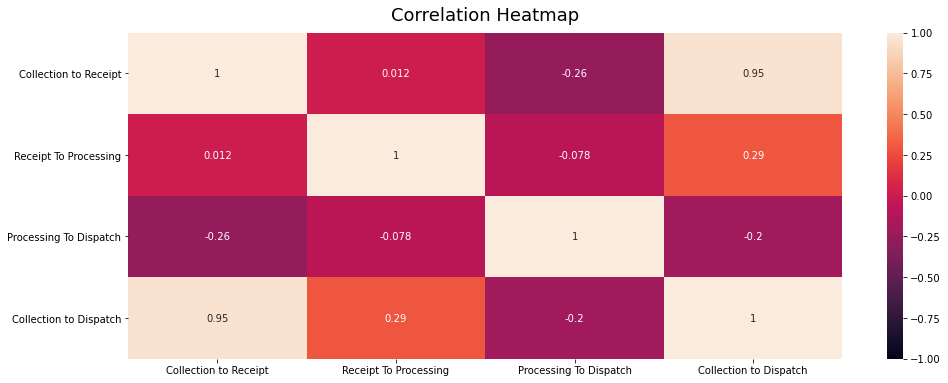

In [50]:
# plotting correlation heatmap
plt.figure(figsize=(16, 6))

dataplot = sns.heatmap(time.corr(),  annot=True,vmin=1, vmax=-1,);
dataplot.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#### Linear relationships

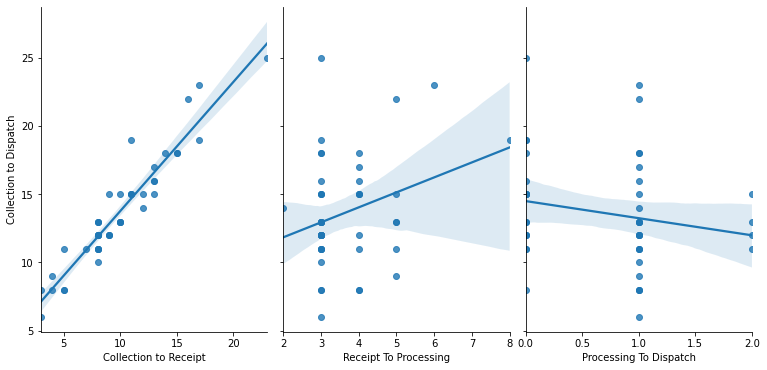

In [51]:
sns.pairplot(time,x_vars=['Collection to Receipt','Receipt To Processing','Processing To Dispatch'],y_vars="Collection to Dispatch", height=5,aspect=0.7,kind='reg');

In [52]:
all_results_tat=all_results_tat.copy()
all_results_tat2=all_results_tat.copy()


In [53]:
initial_PCR_df=all_results_tat.loc[all_results_tat['PCR Type'] == 'Initial PCR (6 week or first contact)']


In [54]:
initial_PCR_df=initial_PCR_df.copy()
initial_PCR_df['TAT(days)'] = initial_PCR_df['TAT(days)'].apply(lambda x : x if x > 0 else 0)


In [55]:
all_results_tat=initial_PCR_df.loc[(all_results_tat['TAT(days)']!=0)]

initial_PCRs=len(all_results_tat['PCR Type'])

In [56]:
less_than_2_days=all_results_tat[(all_results_tat['TAT(days)']<=2)]
less_than_2_days
less_than_2_days=int(less_than_2_days['TAT(days)'].count())
# less_than_2_days


two_to_7_days=all_results_tat[(all_results_tat['TAT(days)']>2 )& (all_results_tat['TAT(days)']<=7)]
two_to_7_days=int(two_to_7_days['TAT(days)'].count())
# two_to_7_days

seven_to_14_days=all_results_tat[(all_results_tat['TAT(days)']>7 )& (all_results_tat['TAT(days)']<=14)]
seven_to_14_days=int(seven_to_14_days['TAT(days)'].count())
# seven_to_14_days

fourteen_to_30_days=all_results_tat[(all_results_tat['TAT(days)']>14 )& (all_results_tat['TAT(days)']<=30)]
fourteen_to_30_days=int(fourteen_to_30_days['TAT(days)'].count())
# fourteen_to_30_days

above_30_days=all_results_tat[(all_results_tat['TAT(days)']>30 )]
above_30_days=int(above_30_days['TAT(days)'].count())
# above_30_days

In [57]:
data = {'Initial EID test done':[initial_PCRs],
        'TAT < 2 days':[less_than_2_days],'TAT 2-7 days':[two_to_7_days],
        'TAT 7-14 days':[seven_to_14_days],'TAT 14-30 days':[fourteen_to_30_days],'TAT >30 days':[above_30_days],}
 
# Create DataFrame
tat_df = pd.DataFrame(data)
tat_df=tat_df.T.reset_index()
tat_df.columns=['Turn Around Time (TAT)','values']
tat_df['%']=round(tat_df['values']/tat_df['values'].max()*100).astype(int).astype(str)+"%"
tat_df['percentage']=tat_df['values'].astype(str)+" ("+tat_df['%']+")"
# tat_df

In [58]:
fig=px.bar(tat_df,x='Turn Around Time (TAT)',y='values',title='<b>INITIAL PCRs TURN AROUND TIME DURING THE REVIEW PERIOD</b>',
           text='percentage',)
#           color_continuous_scale=["green", "yellow", "red"])
fig.update_traces( textposition='outside')
# fig.update_layout(uniformtext_minsize=9, uniformtext_mode='hide')
# fig.update_xaxes(tickangle=45)
fig.show()

In [59]:
less_than_2_days=all_results_tat2[(all_results_tat2['TAT(days)']<=2)]
less_than_2_days
less_than_2_days=int(less_than_2_days['TAT(days)'].count())
# less_than_2_days


two_to_7_days=all_results_tat2[(all_results_tat2['TAT(days)']>2 )& (all_results_tat2['TAT(days)']<=7)]
two_to_7_days=int(two_to_7_days['TAT(days)'].count())
# two_to_7_days

seven_to_14_days=all_results_tat2[(all_results_tat2['TAT(days)']>7 )& (all_results_tat2['TAT(days)']<=14)]
seven_to_14_days=int(seven_to_14_days['TAT(days)'].count())
# seven_to_14_days

fourteen_to_30_days=all_results_tat2[(all_results_tat2['TAT(days)']>14 )& (all_results_tat2['TAT(days)']<=30)]
fourteen_to_30_days=int(fourteen_to_30_days['TAT(days)'].count())
# fourteen_to_30_days

above_30_days=all_results_tat2[(all_results_tat2['TAT(days)']>30 )]
above_30_days=int(above_30_days['TAT(days)'].count())
# above_30_days

In [60]:
data = {'EID tests done':[pcr_done],
        'TAT < 2 days':[less_than_2_days],'TAT 2-7 days':[two_to_7_days],
        'TAT 7-14 days':[seven_to_14_days],'TAT 14-30 days':[fourteen_to_30_days],'TAT >30 days':[above_30_days],}
 
# Create DataFrame
tat_df = pd.DataFrame(data)
tat_df=tat_df.T.reset_index()
tat_df.columns=['Turn Around Time (TAT)','values']
tat_df['%']=round(tat_df['values']/tat_df['values'].max()*100).astype(int).astype(str)+"%"
tat_df['percentage']=tat_df['values'].astype(str)+" ("+tat_df['%']+")"
# tat_df

In [61]:
fig=px.bar(tat_df,x='Turn Around Time (TAT)',y='values',title='<b>TURN AROUND TIME (ALL PCR) DURING THE REVIEW PERIOD</b>',
           text='percentage',)
#           color_continuous_scale=["green", "yellow", "red"])
fig.update_traces( textposition='outside')
# fig.update_layout(uniformtext_minsize=9, uniformtext_mode='hide')
# fig.update_xaxes(tickangle=45)
fig.show()

In [62]:
# px.scatter(time,x='Processing To Dispatch',y='collection to receipt',trendline="ols",
#            color='collection to receipt',
#            title='Processing vs days spent for NASCOP to receive samples',
#            opacity=0.65,trendline_color_override='green',hover_data=["Facilty"])

In [63]:
# px.scatter(time,x='Collection to Dispatch',y='collection to receipt',
#            trendline="ols",color="collection to receipt",
#            title='TAT(days) vs days spent for NASCOP to receive samples',
#            opacity=0.65,trendline_color_override='red',hover_data=["Facilty"])

In [64]:
# px.scatter(time,x='Collection to Dispatch',y='Processing To Dispatch', trendline="ols",title='collection to dispatch vs Processing To Dispatch',opacity=0.65,trendline_color_override='red',
#           color='Processing To Dispatch',hover_data=["Facilty"])